In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

In [73]:
data = pd.read_csv("/Users/ahmadkhair/ahmed/IBM machine learning/5- Deep Learning and Reinforcement Learning/Week 9 - Reinforcement Learning - Final Project/tweet_emotions.csv")
plt.style.use('fivethirtyeight')

In [74]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [114]:
data.shape

(40000, 3)

<Axes: xlabel='count', ylabel='sentiment'>

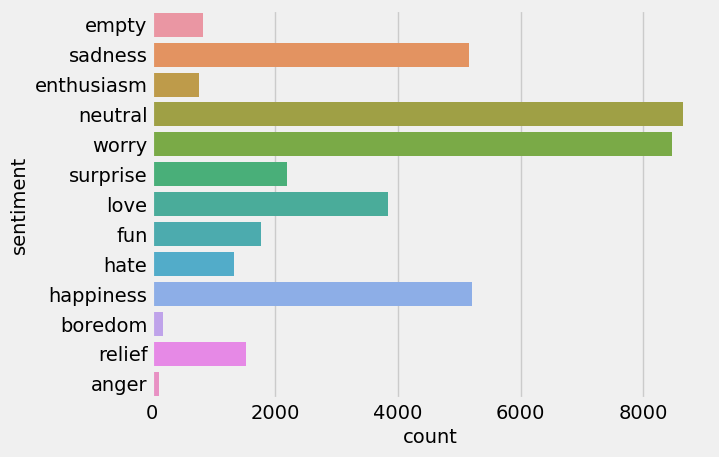

In [75]:
sns.countplot(y=data["sentiment"])

## Data Cleanup and Prepare

In [76]:
stop_words = set(stopwords.words('english'))
from nltk.stem import RegexpStemmer
snowball = RegexpStemmer('ing$|s$|e$|able$', min=4)

data['content'] = data['content'].apply(lambda x: " ".join([snowball.stem(re.sub(r'[^\w\d]', "", word)) for word in x.lower().split() if word not in stop_words]))

X = data["content"]
tokenize = Tokenizer()

tokenize.fit_on_texts(X)
max_length = 64
vocab_size = len(tokenize.word_index) + 1
X = pad_sequences(tokenize.texts_to_sequences(X), maxlen=max_length, padding="post")

## Preparation of Quantum5

In [77]:
n_qubits = 2
dev = qml.device("default.qubit", wires = n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires = range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

weight_shapes = {"weights": (3, n_qubits, 3)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)
clayer1 = tf.keras.layers.Dense(2)
clayer2 = tf.keras.layers.Dense(13, activation = "softmax")
model = tf.keras.models.Sequential([clayer1, qlayer, clayer2])
opt = tf.keras.optimizers.SGD(learning_rate=0.8)
model.compile(opt, loss= 'mae')

## Preparation of Label

In [79]:
Y = data['sentiment']
from sklearn.preprocessing import LabelEncoder

func = LabelEncoder()

Y = func.fit_transform(Y)
Y = tf.convert_to_tensor(Y)

X = tf.constant(X)
Y = tf.one_hot(Y, depth=1)

## Model Fitting

In [81]:
model.fit(X, Y, epochs = 1, batch_size = 256, shuffle = True, steps_per_epoch = 1, validation_split=0.1)

1/1 [==============================] - 62s 62s/step - loss: 0.0769 - val_loss: 0.0773


In [ ]:
## Preparation of Prediction Data and Prediction Equation

In [106]:
a = "I'm having a bad day"
tokenize.fit_on_texts(a)
tokenize.word_index
max_length - 64
vocab_size = len(tokenize.word_index) + 1
a = pad_sequences(tokenize.texts_to_sequences(a), maxlen= max_length, padding = "post")

In [107]:
a = tf.constant(a)
prediction = model.predict(a)

1/1 [==============================] - 0s 303ms/step


In [108]:
ap = []
for i in range(len(prediction)):
    ap.append(np.argmax(prediction[i]))
    np.argmax(ap)

In [109]:
np.argmax(ap)

6

In [110]:
result = np.argmax(ap)
result = np.array(result).reshape(1)
result

array([6])

In [111]:
func.inverse_transform(result)

array(['hate'], dtype=object)